In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [2]:
df2 = pd.read_excel("../markaFile/Volvo.xlsx",sheet_name="Sheet1")

In [3]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [4]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_740,Seri_850,Seri_940,...,Model_2.8 T6,Model_2.9 T6 Executive,Model_3.0,Model_GL TD,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik,Vites Tipi_Yarı Otomatik
0,650000,0.181818,0.361111,0.000000,0.689139,7.0,1.0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
1,1038000,0.454545,1.388889,-0.298077,-0.771536,0.0,0.0,0,0,0,...,0,0,0,0,1,0,0,0,1,0
2,209900,-1.272727,2.166667,2.038462,0.801498,NaN,NaN,0,0,0,...,0,0,0,0,0,0,1,1,0,0
3,699000,0.090909,2.166667,0.168269,0.209738,NaN,NaN,0,0,0,...,0,0,0,0,1,0,0,0,0,1
4,425000,-0.181818,0.194444,0.000000,0.247191,NaN,NaN,0,0,0,...,0,0,0,0,0,1,0,1,0,0


In [5]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [7]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [8]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [9]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_9156\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,225725.816905,2.580735e+10,160646.669666,93758.812139


In [10]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [11]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:44:48,063] A new study created in memory with name: no-name-9678e20f-074b-441b-a12b-07005f84d04c
[I 2023-05-23 21:44:48,225] Trial 1 finished with value: 895417.2173401206 and parameters: {'colsample_bytree': 0.3, 'subsample': 0.6, 'learning_rate': 0.020636509516122645, 'max_depth': 14, 'min_child_weight': 107}. Best is trial 1 with value: 895417.2173401206.
[I 2023-05-23 21:44:48,229] Trial 4 finished with value: 990669.9149602156 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.0002278655171799081, 'max_depth': 12, 'min_child_weight': 206}. Best is trial 1 with value: 895417.2173401206.
[I 2023-05-23 21:44:48,233] Trial 3 finished with value: 990669.9149602156 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.6, 'learning_rate': 0.003828638650456714, 'max_depth': 14, 'min_child_weight': 267}. Best is trial 1 with value: 895417.2173401206.
[I 2023-05-23 21:44:48,246] Trial 7 finished with value: 926504.7533246651 and parameters: {'

[I 2023-05-23 21:44:49,505] Trial 29 finished with value: 402999.7517746746 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.4060290709689397, 'max_depth': 12, 'min_child_weight': 46}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:44:49,509] Trial 31 finished with value: 554959.4259008999 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.10596370924277207, 'max_depth': 11, 'min_child_weight': 41}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:44:49,579] Trial 32 finished with value: 644252.088123693 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.07170472792518745, 'max_depth': 11, 'min_child_weight': 45}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:44:49,612] Trial 33 finished with value: 612322.5902891002 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.08680318940497009, 'max_depth': 11, 'min_child_weigh

[I 2023-05-23 21:44:51,376] Trial 60 finished with value: 359287.77007763775 and parameters: {'colsample_bytree': 0.7, 'subsample': 0.8, 'learning_rate': 0.12960909595052514, 'max_depth': 3, 'min_child_weight': 11}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:44:51,476] Trial 61 finished with value: 545609.603694089 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.14709195841937048, 'max_depth': 4, 'min_child_weight': 60}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:44:51,549] Trial 62 finished with value: 584938.5604317631 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.1292990531422964, 'max_depth': 4, 'min_child_weight': 76}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:44:51,568] Trial 65 finished with value: 699693.1969175519 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.6, 'learning_rate': 0.14708228585240277, 'max_depth': 4, 'min_child_weight':

[I 2023-05-23 21:44:53,176] Trial 90 finished with value: 338542.6822015085 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.5, 'learning_rate': 0.1849363545236842, 'max_depth': 9, 'min_child_weight': 13}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:44:53,206] Trial 91 finished with value: 240724.95124766784 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.18953828251789576, 'max_depth': 9, 'min_child_weight': 9}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:44:53,270] Trial 92 finished with value: 271114.2764111788 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.19784025646604386, 'max_depth': 9, 'min_child_weight': 12}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:44:53,287] Trial 93 finished with value: 318061.6497186703 and parameters: {'colsample_bytree': 1.0, 'subsample': 0.7, 'learning_rate': 0.2024192175194101, 'max_depth': 9, 'min_child_weight': 

[I 2023-05-23 21:44:55,323] Trial 119 finished with value: 195603.37236698886 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.4356533898146423, 'max_depth': 6, 'min_child_weight': 6}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:44:55,539] Trial 121 finished with value: 254473.1527565428 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.4968071513029031, 'max_depth': 6, 'min_child_weight': 15}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:44:55,544] Trial 122 finished with value: 440222.6669365273 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.4919097686096836, 'max_depth': 6, 'min_child_weight': 53}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:44:55,608] Trial 123 finished with value: 391649.1721360552 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.5, 'learning_rate': 0.49416999075996365, 'max_depth': 6, 'min_child_weight

[I 2023-05-23 21:44:57,296] Trial 148 finished with value: 395560.27122279425 and parameters: {'colsample_bytree': 0.9, 'subsample': 0.5, 'learning_rate': 0.16518234355475317, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:44:57,365] Trial 151 finished with value: 413747.82774571836 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.16575394519138742, 'max_depth': 4, 'min_child_weight': 20}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:44:57,452] Trial 152 finished with value: 324189.4488124076 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.15951830779063123, 'max_depth': 4, 'min_child_weight': 18}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:44:57,714] Trial 153 finished with value: 174818.3573398048 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3890922015114645, 'max_depth': 5, 'min_child_we

[I 2023-05-23 21:44:59,969] Trial 179 finished with value: 204552.37811635842 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3343919313984628, 'max_depth': 3, 'min_child_weight': 6}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:45:00,063] Trial 184 finished with value: 170649.02322614763 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.33785675315354846, 'max_depth': 3, 'min_child_weight': 7}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:45:00,128] Trial 181 finished with value: 179626.84796053532 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.3304964309378647, 'max_depth': 3, 'min_child_weight': 5}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:45:00,162] Trial 182 finished with value: 661356.5337250313 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.32425160351417887, 'max_depth': 3, 'min_child_weigh

[I 2023-05-23 21:45:02,471] Trial 207 finished with value: 966572.878643537 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.0028398304584227358, 'max_depth': 5, 'min_child_weight': 1}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:45:02,630] Trial 211 finished with value: 204117.59783470814 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.409854075770997, 'max_depth': 6, 'min_child_weight': 11}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:45:02,694] Trial 213 finished with value: 200374.60984516158 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.26839089416995404, 'max_depth': 6, 'min_child_weight': 1}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:45:02,694] Trial 212 finished with value: 196368.14527361415 and parameters: {'colsample_bytree': 0.7, 'subsample': 1.0, 'learning_rate': 0.2656334888910497, 'max_depth': 5, 'min_child_weig

[I 2023-05-23 21:45:05,269] Trial 239 finished with value: 198502.79216505578 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.36198436420406443, 'max_depth': 6, 'min_child_weight': 6}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:45:05,291] Trial 241 finished with value: 169352.05442591826 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.372961627615096, 'max_depth': 6, 'min_child_weight': 7}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:45:05,461] Trial 242 finished with value: 856849.8948704284 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.016961487006358706, 'max_depth': 6, 'min_child_weight': 6}. Best is trial 19 with value: 128561.77389641081.
[I 2023-05-23 21:45:05,522] Trial 244 finished with value: 200677.47351405522 and parameters: {'colsample_bytree': 1.0, 'subsample': 1.0, 'learning_rate': 0.35852416132830006, 'max_depth': 6, 'min_child_weig

In [12]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 128561.7739
Best params:
	colsample_bytree: 1.0
	subsample: 0.5
	learning_rate: 0.47078674458361497
	max_depth: 11
	min_child_weight: 2


In [13]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.4],
                  "max_depth": [9,11],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [1],
               'subsample': [0.5],
               'min_child_weight': [2]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 1, 'learning_rate': 0.1, 'max_depth': 11, 'min_child_weight': 2, 'n_estimators': 500, 'subsample': 0.5}
{'TestDeger': 239431.84457085602, 'MSE': 21860720693.613102, 'RMSE': 147853.71383097925, 'MAE': 88519.62786020132}


In [14]:
r2 = r2_score(y_test, y_pred)
r2

0.9497583116440412

In [15]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.927882743986662

In [17]:
marka_model = joblib.dump(grid_final_model, "Volvo.pkl")

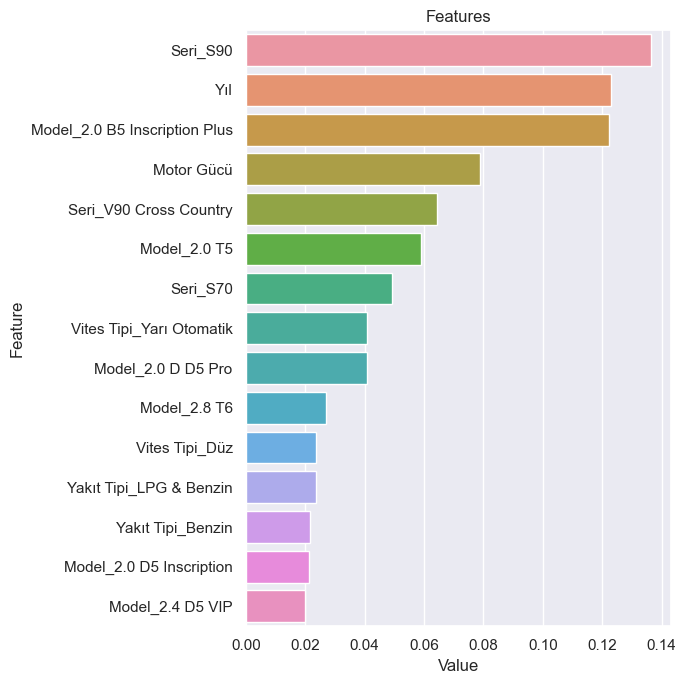

In [16]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)